## Fake News Detection

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold


from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from yellowbrick.text import FreqDistVisualizer

import re
import string

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("amazon_database/fake_or_real_news.csv")
# Set index
df = df.set_index("Unnamed: 0") 
df.head()

,title,text,label
Unnamed: 0,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [3]:
df = df.reset_index(drop=True)

In [4]:
# FAKE news : 0
# REAL news : 1

df["type"] = 0
df.loc[df.label == "REAL", "type"] = 1
df.head()

,title,text,label,type
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,1
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,1


In [8]:
import unicodedata

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')


def clean_text(text):
    
    text = text.lower() # lowercase text
    
    text = text.strip()
    
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    
    text = BAD_SYMBOLS_RE.sub(' ', text) 
    
    text = re.sub(r'\d+', ' ', text)
    
    # Remove all the special characters
    text = re.sub(r'\W+', ' ', text)
    
    text = re.sub(r'[?|$|.|!]',r' ', text)
    
    # Remove tickers
    text = re.sub(r'\$\w*',' ', text)
    
    # Remove URLs
    #text = re.sub(r'https?:\/\/.*\/\w*','', text)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', ' ', text, flags=re.MULTILINE)
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', text)
    
    text = re.sub(r"[^a-zA-Z0-9]", r" ", text)
    
    # Remove puncutation
    text = re.sub(r'[' + string.punctuation + ']+', ' ', text)
    
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Remove stopwords 
    stopwords = set(line.strip() for line in open('stopwords.txt'))
    
    words = [w for w in tokens if w not in stopwords and w.isalpha() and len(w) > 2]
    
    # Wordnet Lemmatizer
    #lemmatizer = WordNetLemmatizer()
    #lemme = [lemmatizer.lemmatize(word) for word in words]
    
    ps = PorterStemmer()
    text1 = filter(lambda x: isinstance(x,str) , words)
    stemmed_text = [ps.stem(word) for word  in text1]
    stemmed_text = " ".join(stemmed_text)
    return stemmed_text
    
    #text = ' '.join(words)
    
    #return text

In [9]:
text_ = df.text
cleaned_text = []
for text in text_:
    cleaned_text.append(clean_text(text))

df['cleaned_text'] = cleaned_text

In [10]:
title_ = df.title
cleaned_title = []
for title in title_:
    cleaned_title.append(clean_text(title))

df['cleaned_title'] = cleaned_title

In [11]:
df["mix"] = df["cleaned_title"].map(str) + " " + df["cleaned_text"]

In [12]:
df = df[['cleaned_title','cleaned_text','mix','type']]

In [13]:
df.head()

,cleaned_title,cleaned_text,mix,type
0,smell hillari fear,daniel greenfield shillman journal fellow free...,smell hillari fear daniel greenfield shillman ...,0
1,watch exact moment paul ryan commit polit suic...,googl pinterest digg linkedin reddit stumbleup...,watch exact moment paul ryan commit polit suic...,0
2,kerri pari gestur sympathi,secretari state john kerri monday stop pari we...,kerri pari gestur sympathi secretari state joh...,1
3,berni support twitter erupt anger dnc warn,kayde king kaydeek novemb lesson tonight dem l...,berni support twitter erupt anger dnc warn kay...,0
4,battl york primari matter,primari day york front runner hillari clinton ...,battl york primari matter primari day york fro...,1


In [14]:
X = df.mix
#X = df.drop(["title","text","label","type","cleaned_text","cleaned_title"], axis=1)
y = df.type

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [15]:
from sklearn.metrics import classification_report

nb = Pipeline([('vector', TfidfVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


y_pred_nb = nb.predict(X_test)

my_tags = ["FAKE","REAL"]

print('Accuracy for MultinomialNB: %.2f' % accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb,target_names=my_tags))

Accuracy for MultinomialNB: 0.84
              precision    recall  f1-score   support

        FAKE       0.97      0.71      0.82       968
        REAL       0.77      0.98      0.86       933

    accuracy                           0.84      1901
   macro avg       0.87      0.84      0.84      1901
weighted avg       0.87      0.84      0.84      1901



In [16]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vector', TfidfVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='log', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)


y_pred_sgd = sgd.predict(X_test)

print('Accuracy for SGDClassifier: %.2f' % accuracy_score(y_test, y_pred_sgd))
print(classification_report(y_test, y_pred_sgd,target_names=my_tags))

Accuracy for SGDClassifier: 0.88
              precision    recall  f1-score   support

        FAKE       0.85      0.93      0.89       968
        REAL       0.92      0.83      0.87       933

    accuracy                           0.88      1901
   macro avg       0.89      0.88      0.88      1901
weighted avg       0.89      0.88      0.88      1901



In [17]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vector', TfidfVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred_lr = logreg.predict(X_test)

print('Accuracy for LogisticRegression: %.2f' % accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr,target_names=my_tags))

Accuracy for LogisticRegression: 0.93
              precision    recall  f1-score   support

        FAKE       0.92      0.94      0.93       968
        REAL       0.94      0.92      0.93       933

    accuracy                           0.93      1901
   macro avg       0.93      0.93      0.93      1901
weighted avg       0.93      0.93      0.93      1901



In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([('vector', TfidfVectorizer()),
               ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=100)),
               ])
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print('Accuracy for RandomForestClassifier: %.2f' % accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf,target_names=my_tags))

Accuracy for RandomForestClassifier: 0.88
              precision    recall  f1-score   support

        FAKE       0.90      0.87      0.88       968
        REAL       0.87      0.89      0.88       933

    accuracy                           0.88      1901
   macro avg       0.88      0.88      0.88      1901
weighted avg       0.88      0.88      0.88      1901



In [19]:
from sklearn.svm import SVC
 
svc = Pipeline([('vector', TfidfVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC(probability=True)),
               ])
svc.fit(X_train, y_train)

y_pred_svc = svc.predict(X_test)

print('Accuracy for SVC: %.2f' % accuracy_score(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc,target_names=my_tags))

Accuracy for SVC: 0.49
              precision    recall  f1-score   support

        FAKE       0.00      0.00      0.00       968
        REAL       0.49      1.00      0.66       933

    accuracy                           0.49      1901
   macro avg       0.25      0.50      0.33      1901
weighted avg       0.24      0.49      0.32      1901



In [20]:
from xgboost import XGBClassifier

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import warnings
warnings.filterwarnings('ignore')

 
xgb = Pipeline([('vector', TfidfVectorizer()),
               ('tfidf', TfidfTransformer()),
                ('clf', XGBClassifier(n_estimators=100)),
               ])

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print('Accuracy for XGBClassifier: %.2f' % accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb,target_names=my_tags))

Accuracy for XGBClassifier: 0.90
              precision    recall  f1-score   support

        FAKE       0.88      0.92      0.90       968
        REAL       0.91      0.87      0.89       933

    accuracy                           0.90      1901
   macro avg       0.90      0.89      0.90      1901
weighted avg       0.90      0.90      0.90      1901



In [21]:
from sklearn.neighbors import KNeighborsClassifier


knn = Pipeline([('vector', TfidfVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier()),
               ])

knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

print('Accuracy for KNeighborsClassifier: %.2f' % accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn,target_names=my_tags))

Accuracy for KNeighborsClassifier: 0.84
              precision    recall  f1-score   support

        FAKE       0.91      0.77      0.84       968
        REAL       0.80      0.92      0.85       933

    accuracy                           0.84      1901
   macro avg       0.85      0.85      0.84      1901
weighted avg       0.85      0.84      0.84      1901



In [22]:
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 
              'XGBoost', 'Random Forest', 'SVC', 'SGD', "Logistic Regression"],
    'Score': [(accuracy_score(y_test, y_pred_knn)*100), (accuracy_score(y_test, y_pred_nb)*100), (accuracy_score(y_test, y_pred_xgb)*100), (accuracy_score(y_test, y_pred_rf)*100), (accuracy_score(y_test, y_pred_svc)*100), (accuracy_score(y_test, y_pred_sgd)*100), (accuracy_score(y_test, y_pred_lr)*100)]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Model')
print(result_df)

                         Score
Model                         
Logistic Regression  93.108890
XGBoost              89.531825
Random Forest        88.269332
SGD                  88.164124
KNN                  84.481852
Naive Bayes          84.218832
SVC                  49.079432


### Confusion Matrix

In [23]:
import itertools
# Method to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, fig=""):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(b=None)
    plt.savefig(fig + ".png")
    plt.show()

In [24]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_sgb = confusion_matrix(y_test, y_pred_sgd)
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_svc = confusion_matrix(y_test, y_pred_svc)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_knn = confusion_matrix(y_test, y_pred_knn)

Confusion matrix, without normalization
[[688 280]
 [ 20 913]]


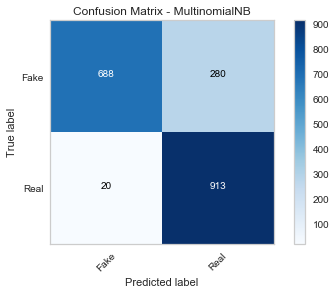

In [25]:
plot_confusion_matrix(cm_nb, classes=['Fake', 'Real'], title='Confusion Matrix - MultinomialNB', fig="confusion_matrix_nb")

Confusion matrix, without normalization
[[902  66]
 [159 774]]


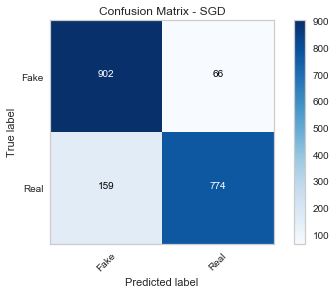

In [26]:
plot_confusion_matrix(cm_sgb, classes=['Fake', 'Real'], title='Confusion Matrix - SGD', fig="confusion_matrix_sgb")

Confusion matrix, without normalization
[[914  54]
 [ 77 856]]


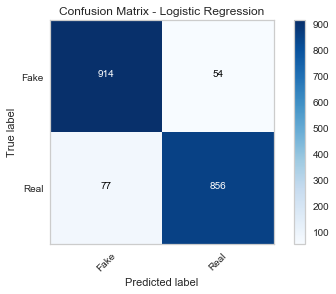

In [27]:
plot_confusion_matrix(cm_lr, classes=['Fake', 'Real'], title='Confusion Matrix - Logistic Regression', fig="confusion_matrix_lr")

Confusion matrix, without normalization
[[844 124]
 [ 99 834]]


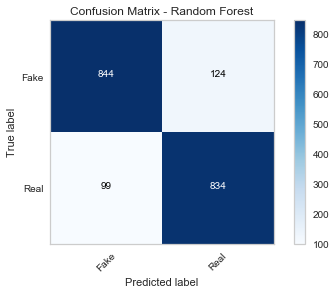

In [28]:
plot_confusion_matrix(cm_rf, classes=['Fake', 'Real'], title='Confusion Matrix - Random Forest', fig="confusion_matrix_rf")

Confusion matrix, without normalization
[[  0 968]
 [  0 933]]


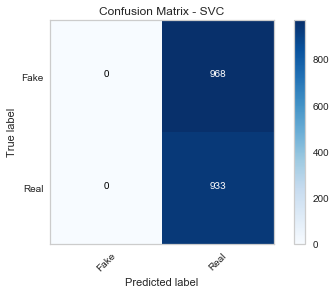

In [29]:
plot_confusion_matrix(cm_svc, classes=['Fake', 'Real'], title='Confusion Matrix - SVC', fig="confusion_matrix_svc")

Confusion matrix, without normalization
[[891  77]
 [122 811]]


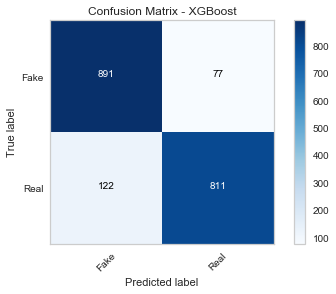

In [30]:
plot_confusion_matrix(cm_xgb, classes=['Fake', 'Real'], title='Confusion Matrix - XGBoost', fig="confusion_matrix_xgb")

Confusion matrix, without normalization
[[747 221]
 [ 74 859]]


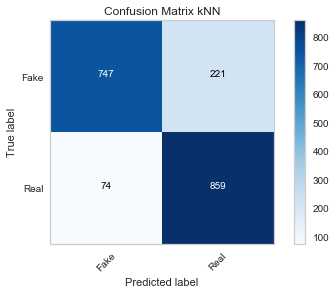

In [31]:
plot_confusion_matrix(cm_knn, classes=['Fake', 'Real'], title='Confusion Matrix kNN', fig="confusion_matrix_knn")

In [32]:
y_prob_nb = nb.predict_proba(X_test)
y_prob_nb = y_prob_nb[:,1]

In [33]:
from sklearn.multiclass import OneVsRestClassifier

# sgd2 = Pipeline([('vector', TfidfVectorizer()),
#                ('tfidf', TfidfTransformer()),
#                ('clf', SGDClassifier(loss='log', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
#               ])

sgd_classifier = OneVsRestClassifier(sgd)

y_prob_sgd = sgd_classifier.fit(X_train, y_train).predict_proba(X_test)
y_prob_sgd = y_prob_sgd[:,1]

In [34]:
y_prob_logreg = logreg.predict_proba(X_test)
y_prob_logreg = y_prob_logreg[:,1]

In [35]:
y_prob_rf = rf.predict_proba(X_test)
y_prob_rf = y_prob_rf[:,1]

In [36]:
svc_classifier = OneVsRestClassifier(svc)

y_prob_svc = svc_classifier.fit(X_train, y_train).predict_proba(X_test)
y_prob_svc = y_prob_svc[:,1]

In [37]:
y_prob_xgb = xgb.predict_proba(X_test)
y_prob_xgb = y_prob_xgb[:,1]

In [38]:
y_prob_knn = knn.predict_proba(X_test)
y_prob_knn = y_prob_knn[:,1]

In [39]:
names = ["MultinomialNB","SGDClassifier","LogisticRegression","RandomForestClassifier","SVC","XGBClassifier","KNeighborsClassifier"]
probs = [y_prob_nb, y_prob_sgd, y_prob_logreg, y_prob_rf, y_prob_svc, y_prob_xgb, y_prob_knn]

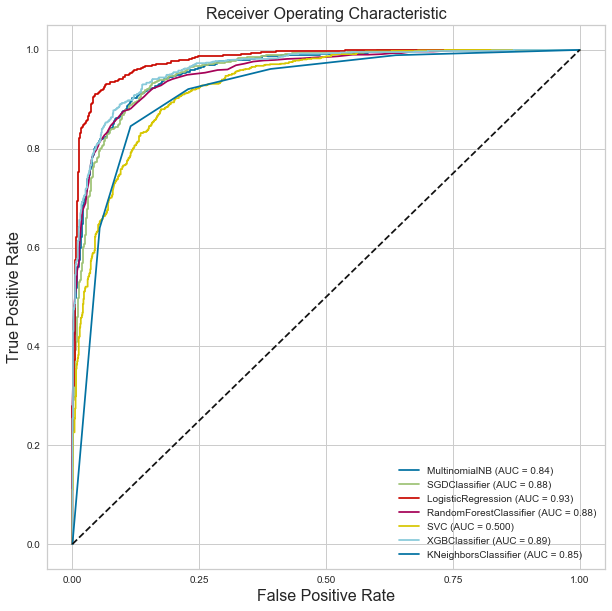

In [41]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)


roc_auc_nb = roc_auc_score(y_test, y_pred_nb)
roc_auc_sgd = roc_auc_score(y_test, y_pred_sgd)
roc_auc_lr = roc_auc_score(y_test, y_pred_lr)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)
roc_auc_svc = roc_auc_score(y_test, y_pred_svc)
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb)
roc_auc_knn = roc_auc_score(y_test, y_pred_knn)


labels = dict(MultinomialNB='MultinomialNB (AUC = %0.2f)' % roc_auc_nb,
              SGDClassifier='SGDClassifier (AUC = %0.2f)' % roc_auc_sgd,
              LogisticRegression='LogisticRegression (AUC = %0.2f)' % roc_auc_lr,
              RandomForestClassifier='RandomForestClassifier (AUC = %0.2f)' % roc_auc_rf,
              SVC='SVC (AUC = %0.3f)' % roc_auc_svc,
              XGBClassifier='XGBClassifier (AUC = %0.2f)' % roc_auc_xgb,
              KNeighborsClassifier="KNeighborsClassifier (AUC = %0.2f)" % roc_auc_knn)


for name, y_prob in zip(names, probs):
    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)

    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    ax.plot(fpr, tpr, label=labels[name])

ax.plot([0, 1], [0, 1], 'k--')
ax.legend(loc=4)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title('Receiver Operating Characteristic',fontsize=16)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.savefig("ROC_Curve.png")
plt.show()

## Real and Fake News -- Frequence and WordCloud

In [42]:
fake = df[df["type"] == 0]
real = df[df["type"] == 1]

### Fake News

In [43]:
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

words_fake = [x.split() for x in fake.cleaned_text.values]
from itertools import chain
cx = Counter(list(chain(*words_fake)))
top = 15
most_common_fake = cx.most_common()[0:]

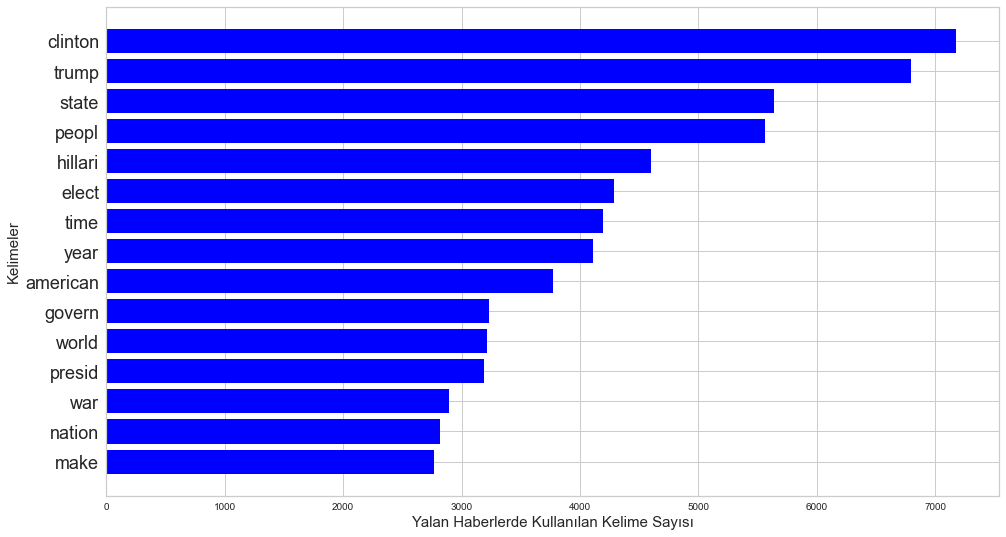

In [44]:
x, y = zip(*most_common_fake[:top])
fig, ax = plt.subplots(1, figsize=(16,9))
ax.barh(range(len(x)), y, color='blue')
ax.invert_yaxis()
ax.set_xlabel('Yalan Haberlerde Kullanılan Kelime Sayısı', fontsize=15)
ax.set_ylabel('Kelimeler' , fontsize=15)
ax.set_yticks(np.arange(len(x)))
ax.set_yticklabels(x, fontsize=18)
plt.savefig("fakenews_frequence.png")
plt.show()

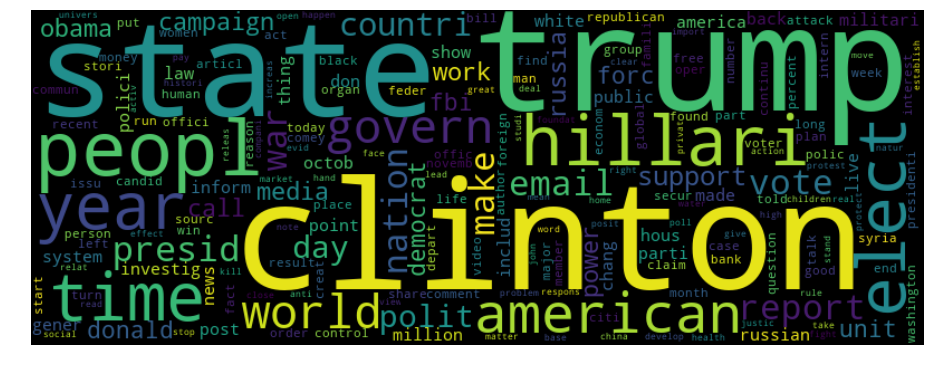

In [45]:
d = {}
for k,v in most_common_fake:
    d[k] = int(v)

wc = WordCloud(relative_scaling=.5, width=800, height=300, background_color='black',stopwords=stopwords).generate_from_frequencies(d)
fig = plt.figure(1,figsize=(16,8), frameon=False)
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.savefig("wordcloud_fakenews.png")
plt.show()

### Real News

In [46]:
words_real = [x.split() for x in real.cleaned_text.values]
from itertools import chain
cx = Counter(list(chain(*words_real)))
top = 15
most_common_real = cx.most_common()[0:]

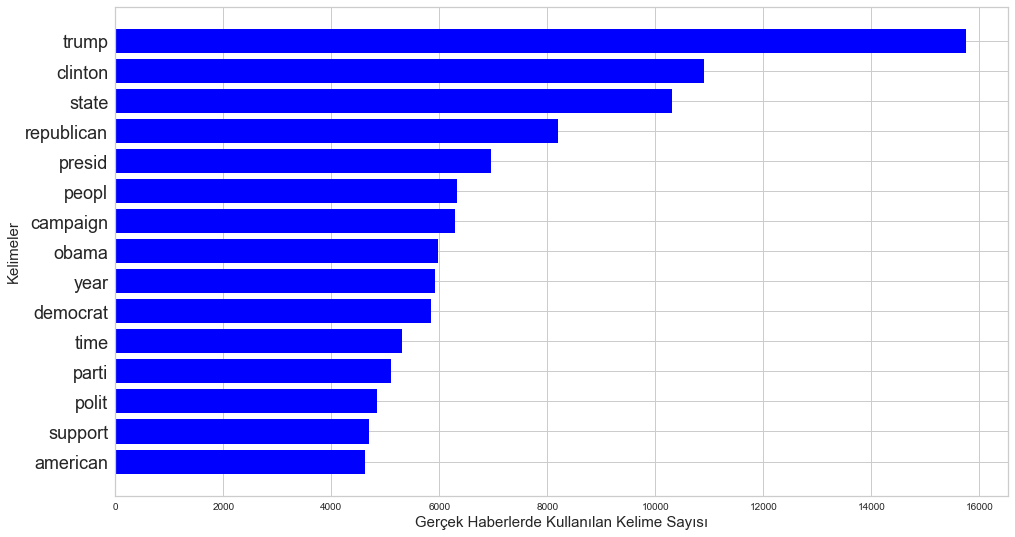

In [47]:
x, y = zip(*most_common_real[:top])
fig, ax = plt.subplots(1, figsize=(16,9))
ax.barh(range(len(x)), y, color='blue')
ax.invert_yaxis()
ax.set_xlabel('Gerçek Haberlerde Kullanılan Kelime Sayısı', fontsize=15)
ax.set_ylabel('Kelimeler' , fontsize=15)
ax.set_yticks(np.arange(len(x)))
ax.set_yticklabels(x, fontsize=18)
plt.savefig("realnews_frequence.png")
plt.show()

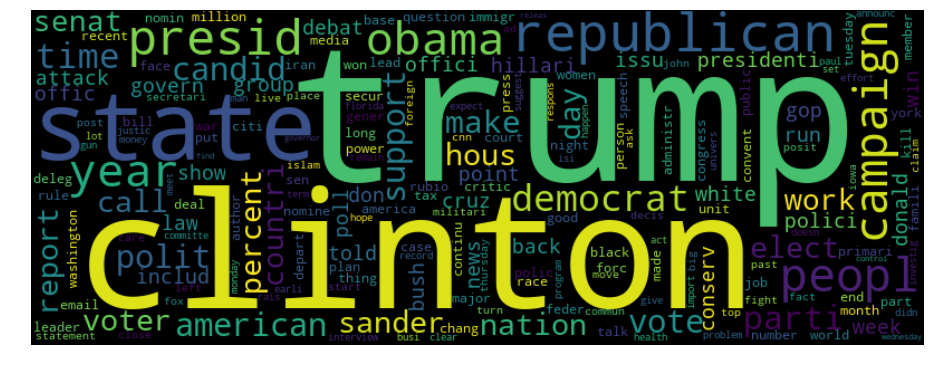

In [48]:
d_ = {}
for k,v in most_common_real:
    d_[k] = int(v)

wc = WordCloud(relative_scaling=.5, width=800, height=300, background_color='black',stopwords=stopwords).generate_from_frequencies(d_)
fig = plt.figure(1,figsize=(16,8), frameon=False)
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.savefig("wordcloud_realnews.png")
plt.show()

### Kfold Cross Validation

In [49]:
from sklearn.model_selection import cross_val_predict, cross_val_score

cv = KFold(n_splits=10)
scores_nb = cross_val_score(nb, X_train, y_train, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_nb.mean(), scores_nb.std() * 2))

Accuracy: 0.83 (+/- 0.04)


In [50]:
scores_sgd = cross_val_score(sgd, X_train, y_train, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_sgd.mean(), scores_sgd.std() * 2))

Accuracy: 0.88 (+/- 0.05)


In [51]:
scores_lr = cross_val_score(logreg, X_train, y_train, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_lr.mean(), scores_lr.std() * 2))

Accuracy: 0.92 (+/- 0.02)


In [52]:
scores_rf = cross_val_score(rf, X_train, y_train, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_rf.mean(), scores_rf.std() * 2))

Accuracy: 0.89 (+/- 0.03)


In [53]:
scores_svc = cross_val_score(svc, X_train, y_train, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_svc.mean(), scores_svc.std() * 2))

Accuracy: 0.50 (+/- 0.06)


In [54]:
scores_xgb = cross_val_score(xgb, X_train, y_train, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_xgb.mean(), scores_xgb.std() * 2))

Accuracy: 0.88 (+/- 0.03)


In [55]:
scores_knn = cross_val_score(knn, X_train, y_train, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_knn.mean(), scores_knn.std() * 2))

Accuracy: 0.85 (+/- 0.03)


In [56]:
kfold = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 
              'XGBoost', 'Random Forest', 'SVC', 'SGD', "Logistic Regression"],
    'Score': [(scores_knn.mean()), (scores_nb.mean()), (scores_xgb.mean()), (scores_rf.mean()), (scores_svc.mean()), (scores_sgd.mean()), (scores_lr.mean())]})

df_kfold = kfold.sort_values(by='Score', ascending=False)
df_kfold = df_kfold.set_index('Model')
print(df_kfold)

                        Score
Model                        
Logistic Regression  0.919716
Random Forest        0.886334
XGBoost              0.884302
SGD                  0.875072
KNN                  0.848228
Naive Bayes          0.833792
SVC                  0.504743
